In [ ]:
import os 
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

In [ ]:
os.environ['KAGGLE_USERNAME'] = "alizehzafar"
os.environ ['KAGGLE_KEY'] = "12eb7f36b7ab2d9c237d6d88b43da6fd"

!kaggle datasets download -d aryashah2k/large-shoe-dataset-ut-zappos50k

!unzip /content/large-shoe-dataset-ut-zappos50k.zip

In [ ]:
def image_extractor(root_dir,image_array,image_labels,label,categories):

    #root_dir = '/kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images/ut-zap50k-images/Boots/Ankle'
    C = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.jpg'):
                jpg_file_path = os.path.join(subdir, file)
                image_array.append(jpg_file_path)
               # image_array.append(cv2.imread(jpg_file_path, cv2.IMREAD_GRAYSCALE))
                #image_labels.append(categories.index(label))
                image_labels.append(label)
                
#print(len(image_array))      
# Do something with the JPG file path

In [ ]:

directory = "/content/ut-zap50k-images-square/ut-zap50k-images-square"
#'/kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square'
subDirectories = ['Boots','Sandals','Shoes','Slippers']
categories = []
image_array=[]
image_labels=[]

for category in subDirectories:
    path = os.path.join(directory,category) #Path to a certain directory
    label = os.path.basename(path)
    print("Label Part 1:",label)
    for category1 in os.listdir(path):
        subpath = os.path.join(path,category1)
        sublabel = os.path.basename(subpath)+" "+label
        print ("Label:",sublabel)
        categories.append(sublabel)
        image_extractor(subpath,image_array,image_labels,sublabel,categories)
        print("1 ",subpath)
        #sublabel = ""
        

print(image_array[0])
print(image_labels[0])
#plt.imshow(image_array[0])
print("Images Length:",len(image_array))
print("Labels Length:",len(image_labels))
print(categories)

In [ ]:
#test_dataframe = pd.DataFrame(
#   {'TestImages': image_array,
#     'TestLabels': image_labels
#   })

filepaths = pd.Series(image_array, name='ImagePaths').astype(str)
Labels = pd.Series(image_labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)


#Resampling it
img_df.head()

,ImagePaths,Labels
0,/content/ut-zap50k-images-square/ut-zap50k-ima...,Mid-Calf Boots
1,/content/ut-zap50k-images-square/ut-zap50k-ima...,Mid-Calf Boots
2,/content/ut-zap50k-images-square/ut-zap50k-ima...,Mid-Calf Boots
3,/content/ut-zap50k-images-square/ut-zap50k-ima...,Mid-Calf Boots
4,/content/ut-zap50k-images-square/ut-zap50k-ima...,Mid-Calf Boots


In [ ]:
img_df = img_df.groupby('Labels').filter(lambda x : len(x)>=10)
img_df['Labels'].value_counts(ascending=True)


Slipper Heels Slippers                  10
Boot Slippers                           14
Athletic Sandals                        14
Crib Shoes Shoes                        23
Over the Knee Boots                     49
Heel Sandals                           126
Prewalker Shoes                        249
Firstwalker Shoes                      369
Boat Shoes Shoes                       629
Slipper Flats Slippers                1259
Clogs and Mules Shoes                 1427
Oxfords Shoes                         2044
Knee High Boots                       2202
Loafers Shoes                         2875
Flats Shoes                           3994
Mid-Calf Boots                        4726
Flat Sandals                          5601
Heels Shoes                           5739
Ankle Boots                           5855
Sneakers and Athletic Shoes Shoes    12859
Name: Labels, dtype: int64

In [ ]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15


x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio, stratify=img_df['Labels'])
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio),stratify=x_test['Labels']) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_test = x_test.copy()
x_tr = x_test



Shape of Training Data :  (35044, 2)
Shape of Testing Data :  (7510, 2)
Shape of Validation Data :  (7510, 2)


In [ ]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='ImagePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='ImagePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='ImagePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 35044 validated image filenames belonging to 20 classes.
Found 7510 validated image filenames belonging to 20 classes.
Found 7510 validated image filenames belonging to 20 classes.


In [ ]:
model = keras.Sequential([

    # First Convolutional Block
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                 input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),

    # Second Convolutional Block
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    tf.keras.layers.MaxPool2D(),

    # Third Convolutional Block
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    tf.keras.layers.MaxPool2D(),

    # Classifier Head
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(740, activation="relu"),
    tf.keras.layers.Dense(20, activation="softmax"),
])
#model.summary()

model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

In [ ]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
model_fit = model.fit(x_train,
                      validation_data = x_val, 
                      epochs = 10, callbacks=Callback)

Epoch 1/10
1096/1096 [==============================] - 98s 89ms/step - loss: 0.0618 - accuracy: 0.7711 - val_loss: 0.0496 - val_accuracy: 0.8096
Epoch 2/10
1096/1096 [==============================] - 95s 86ms/step - loss: 0.0388 - accuracy: 0.8567 - val_loss: 0.0423 - val_accuracy: 0.8443
Epoch 3/10
1096/1096 [==============================] - 96s 88ms/step - loss: 0.0236 - accuracy: 0.9174 - val_loss: 0.0500 - val_accuracy: 0.8427
Epoch 4/10
1096/1096 [==============================] - 92s 84ms/step - loss: 0.0109 - accuracy: 0.9664 - val_loss: 0.0650 - val_accuracy: 0.8415
Epoch 5/10
1096/1096 [==============================] - 90s 82ms/step - loss: 0.0065 - accuracy: 0.9837 - val_loss: 0.0776 - val_accuracy: 0.8433
Epoch 6/10
1096/1096 [==============================] - 92s 84ms/step - loss: 0.0043 - accuracy: 0.9912 - val_loss: 0.0993 - val_accuracy: 0.8394
Epoch 7/10
1096/1096 [==============================] - 91s 83ms/step - loss: 0.0039 - accuracy: 0.9933 - val_loss: 0.0986 -

In [ ]:
test_accuracy = model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

235/235 [==============================] - 13s 57ms/step - loss: 0.1107 - accuracy: 0.8394
Test accuracy is :  83.9414119720459 %


In [ ]:
probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)

235/235 [==============================] - 13s 56ms/step


In [ ]:
print("Prediction(0)",predictions[0])
print("Prediction(1)",np.argmax(predictions[0]))
print("Prediction(2)",categories[np.argmax(predictions[0])])
print("")

Prediction(0) [0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416
 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416
 0.04604416 0.12516098 0.04604416 0.04604416 0.04604416 0.04604416
 0.04604416 0.04604416]
Prediction(1) 13
Prediction(2) Loafers Shoes



In [ ]:
from PIL import Image
#print(x_tr.head())
x_tr1 = x_tr['ImagePaths'].. to_list()
im = Image.open(""+rx_tr1[0])
im.show()

In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/models/FinalProject1.h5')

In [ ]:
from tensorflow.keras.models import load_model
m = load_model('/content/models/FinalProjectVer3.h5')
pred = m.predict(x_test)

235/235 [==============================] - 13s 55ms/step


# Color Extractor

In [ ]:
print(pred[0])
print(np.argmax(pred[0]))
print(categories[np.argmax(pred[0])])

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_main_colors(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Flatten the image into a 1D array of pixels
    pixels = image.reshape(-1, 3)

    # Calculate the histogram of pixel colors
    hist, bins = np.histogramdd(pixels, bins=256, range=((0, 256), (0, 256), (0, 256)))

    # Find the two most common colors
    indices = np.unravel_index(np.argsort(hist, axis=None)[::-1][:2], hist.shape)
    colors = np.array([bins[i][indices[i]] for i in range(3)])

    # Plot the histogram
    fig, ax = plt.subplots()
    ax.bar(range(len(hist)), hist.flatten())

    # Plot the main colors on the histogram
    for color in colors:
        ax.axvline(color, color='r')

    # Show the plot
    plt.show()

    return colors

In [ ]:
pip install color_extraction

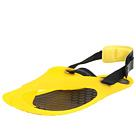

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
img_path = '/7833418.764.jpg'
img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)  # Specify the color conversion flag
cv2_imshow(img)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import color_extraction
def colorChecker(img_path):
  
  img = cv2.imread(img_path)
  #assert img is not None, f"Failed to load image file at path {img_path}"
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

  counts = color_extraction.get_counts(img)
 # print(counts)

  sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
  top_three = sorted_counts[:5]
  print(top_three)

  print("Top three colors:")
  for color, count in top_three:
      print(f"{color}: {count}")

  colors = [color for color, count in top_three]
  counts = [count for color, count in top_three]

  plt.bar(colors, counts)
  plt.xlabel('Colors')
  plt.ylabel('Counts')
  plt.title('Top Three Colors')
  plt.show()


User End Code

In [ ]:
import cv2
import matplotlib.pyplot as plt
import color_extraction
def userOutput(img_path,AIModel):
  
  img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reading color images
  img = cv2.resize(img, (224,224))
  image_array = []
  image_array.append(img)
  image_array = np.array(image_array)
  probability_model = tf.keras.Sequential([AIModel,tf.keras.layers.Softmax()])
  prediction = probability_model.predict(image_array)
  print("Type of Shoe:",categories[np.argmax(prediction[0])])
  print("Color:")
  colorChecker(img_path)

  cv2_imshow(img)


#sentence = format_prediction(sentence)
#colorChecker(img_path)
#model.predict(img_path)
#def userOutput(path):


In [ ]:

  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras import models
m = models.load_model('/content/drive/MyDrive/FinalProject1.h5')


In [ ]:
pred1=m.predict(x_test)

235/235 [==============================] - 21s 57ms/step


In [ ]:
print (pred1)

[[4.5289628e-08 1.1882567e-13 6.2956479e-10 ... 2.2219204e-10
  1.0967580e-11 5.7274763e-10]
 [9.9999988e-01 2.4458740e-28 4.1114899e-27 ... 6.4569323e-22
  5.8336793e-32 8.2694143e-08]
 [5.7642522e-09 1.5462489e-20 1.6394847e-16 ... 5.0176707e-12
  1.0330076e-18 1.2355181e-11]
 ...
 [1.0000000e+00 6.6968136e-27 2.9497081e-24 ... 1.4905800e-24
  1.0458869e-29 3.1084976e-16]
 [5.6589480e-23 6.7899838e-20 9.8421511e-23 ... 1.0000000e+00
  8.3245097e-14 3.0734313e-16]
 [3.1043682e-27 2.4779467e-27 2.1936479e-27 ... 1.4809005e-23
  1.2387593e-32 1.0000000e+00]]


1/1 [==============================] - 0s 92ms/step
Type of Shoe: Athletic Sandals
Color:
[('white', 8536), ('achro', 3722), ('orange', 1266), ('red', 283), ('yellow', 65)]
Top three colors:
white: 8536
achro: 3722
orange: 1266
red: 283
yellow: 65


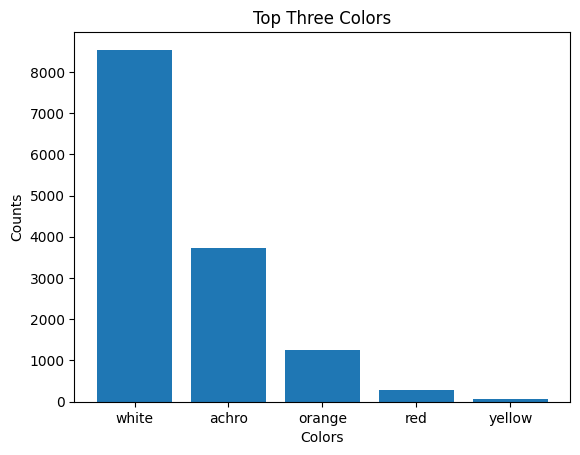

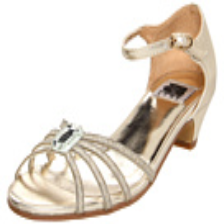

In [ ]:
userOutput('/content/8028140.103693.jpg',m)